In [282]:
using DiffOpt
using Statistics
using COSMO
using JuMP
using Plots
import Random
using LinearAlgebra
using Printf
Base.show(io::IO, f::Float64) = @printf(io, "%1.3f", f) # to reduce float precision while printing

In [584]:
function R2(y_true, y_pred)
    """
        Return the coefficient of determination R2 of the prediction.
        best possible score is 1.0
        it can be negative (because the model can be arbitrarily worse)
    """
    u = sum((y_pred - y_true).^2)  # Regression sum of squares
    v = sum((y_true .- mean(y_true)).^2)  # Total sum of squares
    
    return 1-(u/v)
end

function createProblem(N, D, noise)
    w = rand(D) 
    X = rand(N, D) 
    
    # if noise=0, then there is no need of regularization
    # and alpha=0 will give the best R2 pred score
    Y = X*w .+ noise*randn(N)

    # test train split
    l = Int(N*0.5)
    return X[1:l, :], X[l+1:N, :], Y[1:l], Y[l+1:N]
end

X_train, X_test, Y_train, Y_test = createProblem(800, 30, 4);

In [585]:
function fitRidge(X,Y,α)
    model = Model(() -> diff_optimizer(COSMO.Optimizer))

    N, D = size(X)
    
    # add variables
    @variable(model, w[1:D]>=-10)
    set_optimizer_attribute(model, MOI.Silent(), true)
    
    @objective(
        model,
        Min,
        sum((Y - X*w).*(Y - X*w))/(2.0*N) + α*(w'w),
    )

    optimize!(model)

    loss = objective_value(model)
    return model, w, loss, value.(w)
end

fitRidge (generic function with 1 method)

In [629]:
αs = [0.0, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 7e-2, 2e-1, 3e-1, .5, .7, 1.0]
Rs = Float64[]
mse = Float64[]

for α in αs
    _, _, _, w_train = fitRidge(X_train, Y_train, α) 
    Y_pred = X_test*w_train
    push!(Rs, R2(Y_test, Y_pred))
    push!(mse, sum((Y_pred - Y_test).^2))
end

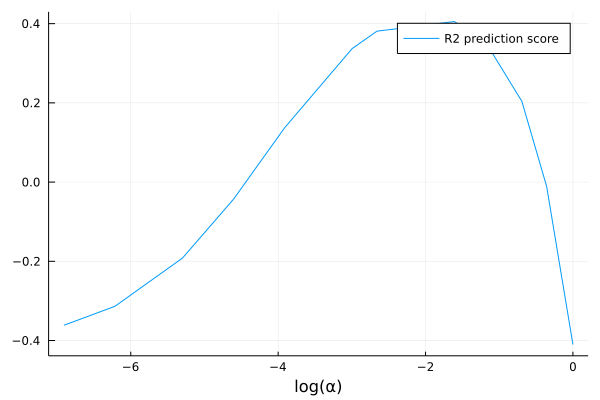

In [741]:
plot(log.(αs), Rs*10, label="R2 prediction score",  xaxis = ("log(α)"))

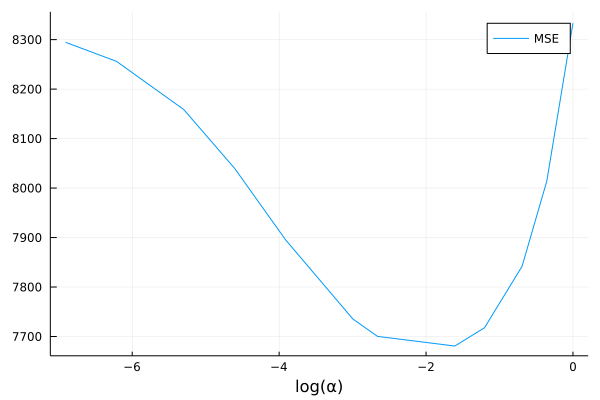

In [740]:
plot(log.(αs), mse, label="MSE", xaxis = ("log(α)"))

# Plotting ∂l/∂α

In [729]:
function ∇model(model, X_train, w, ŵ, α)
    N, D = size(X_train)
    dw = zeros(D)
    ∂w_∂α = zeros(D)

    for i in 1:D
        dw[i] = 1.0 #set

        MOI.set(
            model, 
            DiffOpt.ForwardIn{DiffOpt.QuadraticObjective}(), 
            w[i],
            w[i],
            dw[i]*α
        )

        DiffOpt.forward(model)  # find grad

        ∂w_∂α[i] = MOI.get(
            model,
            DiffOpt.ForwardOut{MOI.VariablePrimal}(), 
            w[i]
        )

        dw[i] = 0.0 #unset
    end
    return sqrt(ŵ'ŵ) + 2α*(ŵ'∂w_∂α) - sum((X_train*∂w_∂α).*(Y_train - X_train*ŵ))/(2*N)
end

∇model (generic function with 2 methods)

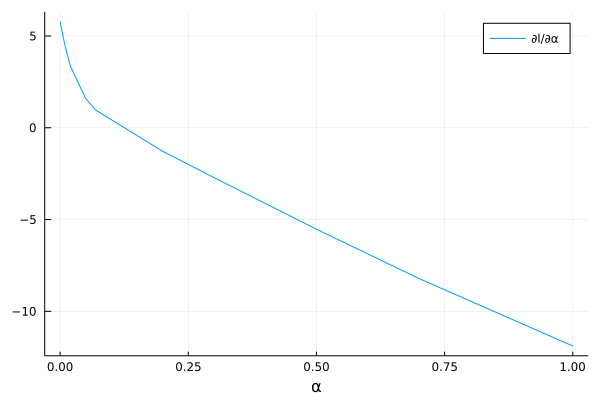

In [742]:
∂l_∂αs = Float64[]

for α in αs
    model, w, _, ŵ = fitRidge(X_train, Y_train, α)

    # testing optimality
    ∂l_∂w = [2*α*ŵ[i] - sum(X_train[:,i].*(Y_train - X_train*ŵ))/N for i in 1:D]
    @assert norm(∂l_∂w) < 1e-4
    
    push!(
        ∂l_∂αs, 
        ∇model(model, X_train, w, ŵ, α)
    )
end

plot(αs, ∂l_∂αs, label="∂l/∂α",  xaxis = ("α"))

# Gradient Descent

In [731]:
"""
    start from initial value of regularization constant
    do gradient descent on alpha
    until the MSE keeps on decreasing
"""
function descent(α, max_iters=25)
    prev_mse = 1e7
    curr_mse = 1e6
    
    α_s = Float64[]
    mse = Float64[]
    
    iter=0
    while curr_mse-10 < prev_mse && iter < max_iters
        iter += 1
        model, w, _, ŵ = fitRidge(X_train, Y_train, α)
        
        #update
        ∂α = ∇model(model, X_train, w, ŵ, α)
        
        α += 0.01*∂α  # make it grow real slow
        
        push!(α_s, α)
        
        Y_pred = X_test*ŵ

        prev_mse = curr_mse
        curr_mse = sum((Y_pred - Y_test).^2) 
        
        push!(mse, curr_mse)
    end
    
    return α_s, mse
end

descent

In [732]:
ᾱ, msē = descent(1.0);

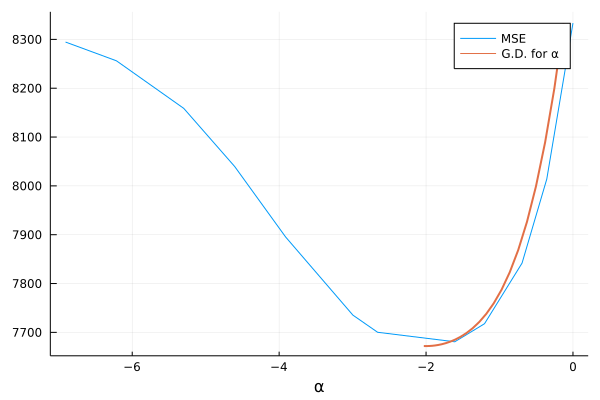

In [743]:
plot(log.(αs), mse, label="MSE", xaxis = ("α"))
plot!(log.(ᾱ), msē, label="G.D. for α", lw = 2)